In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1,grid=False)
import seaborn as sns
from vapeplot import vapeplot
#vapeplot.set_palette('cool')

np.random.seed(3453532)

from data_generator import NormalData, TData
from fitting import NormalFit, NormalSigmaFit, NormalSysFit, TFit

purple = "#FF25DE"
green = "#25FF60"
yellow='#FFF97C'
blue="#36CBFB"

# Systematics

We often deal with systematics in astrophysics. But what does this mean? Unfortunately, it can mean different things to different people. However, we generally accept it as "the model is wrong." But what part of the model? Why do we "fix" systematics by inflating the errors? The real problem comes in with the defintion of "error."

When we say error, we typically are refering the the $\sigma$ parameter of the normal distribution. This defines the innermost region of the normal distribution that contains 68% of the probabilty or area under the curve.

<IPython.core.display.Javascript object>


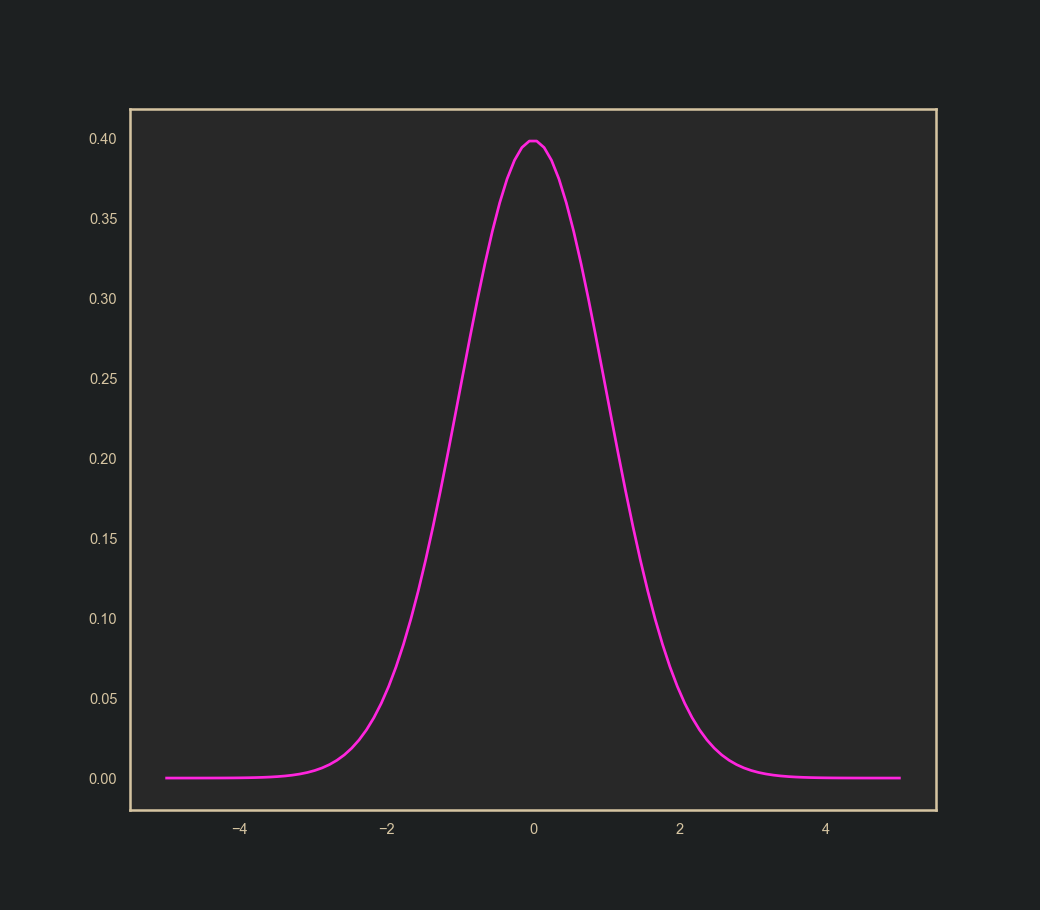

In [14]:
fig, ax = plt.subplots()

xplot = np.linspace(-5,5,100)

yplot = stats.norm.pdf(xplot)

ax.plot(xplot,yplot,color=purple)


fig.savefig('gauss.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


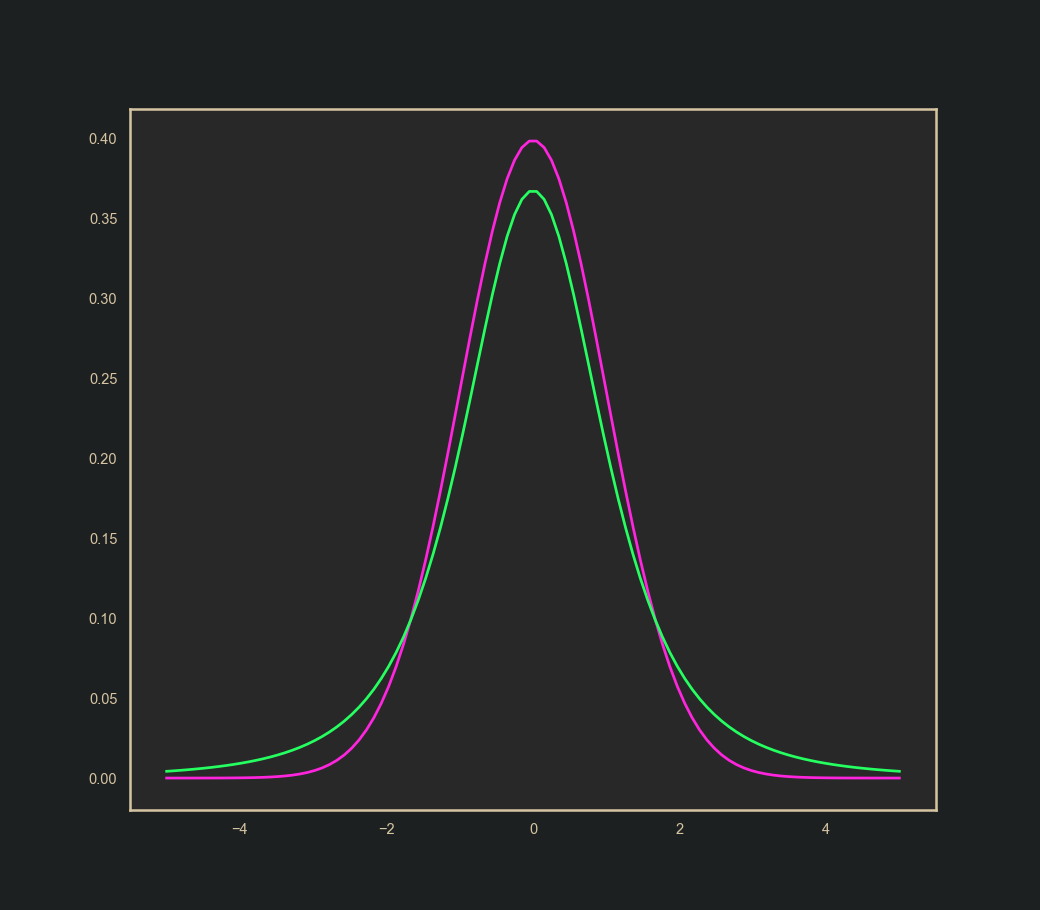

In [20]:
fig, ax = plt.subplots()

xplot = np.linspace(-5,5,100)

yplot = stats.norm.pdf(xplot)

ax.plot(xplot,yplot,color=purple)

yplot = stats.t.pdf(xplot,df=3)

ax.plot(xplot,yplot,color=green)

fig.savefig('gauss_t.pdf', bbox_inches='tight')

When we fit for a parameter in a model (I'm assuming we are all Bayesians here), the marginal distribution for that parameter can be used to calculate an N% credible region. The meaning of this credible region is that the true value of that parameter lies has an N% probabilty of lying within that region. 

We can take a look at what this means via simulation.

# The Gaussian Line

Let's examine the classic Guassion line. What does this mean? This is a model where some predictors ($x$) are linearly related to predicted values ($y_{\rm latent}$) that have been measured with some Gaussian obscuration leading to observed values ($y_{\rm obs}$). 

$$ y_{\rm latent} = mx +b$$

$$ y_{\rm obs} \sim \mathcal{N}\left(y_{\rm latent}, \sigma\right)$$

Notice I've stayed away from the word "error." Indeed, $m$ and $b$ are parameters of this model, but the scale parameter ($\sigma$) of the Guassian distribution can be as well. Typically in astronomy we know are assume $\sigma$ when our data are Gaussian distributed because in these cases, the data are the result of some other modeling process. We hope that we have the correct $\sigma$, but e.g. poor modeling of the measurement process, can result in poorly estimated $\sigma$.

For now, let's assumed we know $\sigma$ (and that the data are Guassian distributed) and simulate some observations.


<IPython.core.display.Javascript object>


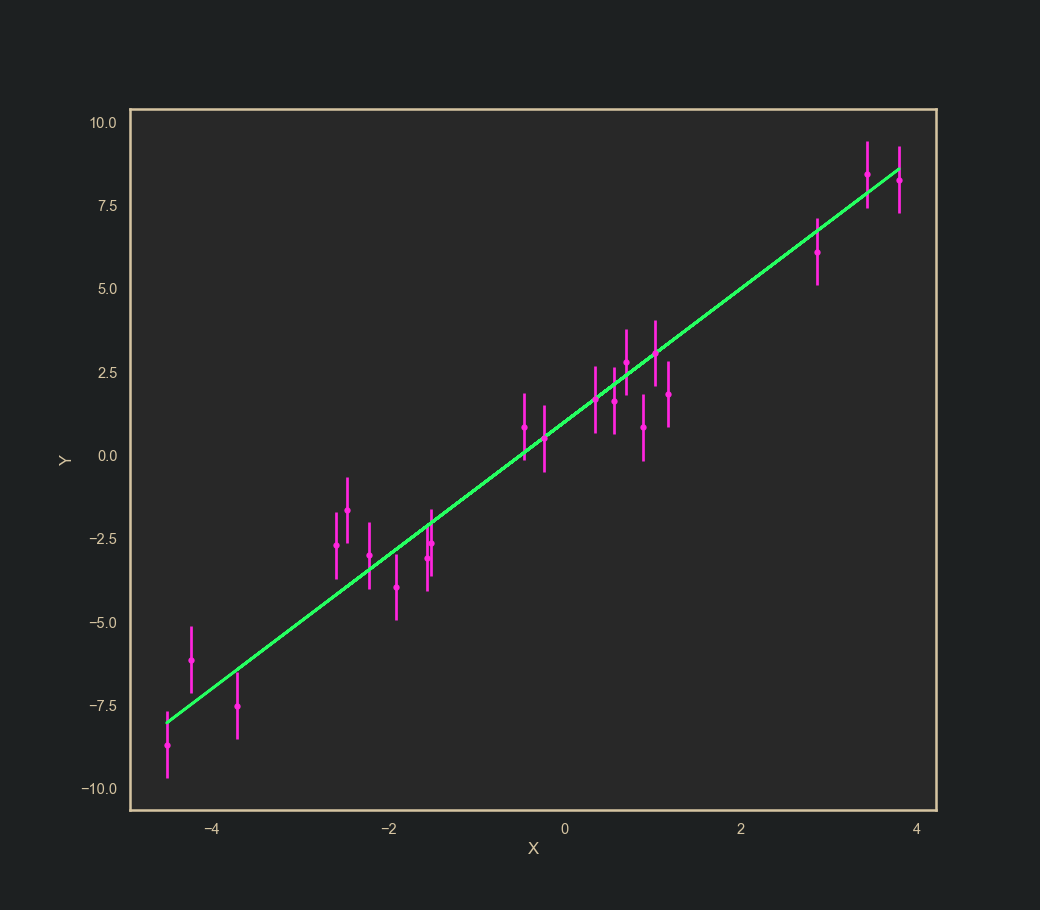

In [3]:

data = NormalData(m_latent=2., b_latent=1., sigma =1)

fig =data.plot(with_latent=True,latent_color=green,data_color=purple);
fig.savefig('ndata.pdf',bbox_inches='tight')

We can plot the simulated data with "error bars," but remember that the data **do not** carry these error bars with them. The data are a result of a generative process of which we have measured a realization.  

We know what values of the line we have simualted, so we can do a fit to see if we recover the true values of the line. The package I've included will generate the data and fit it via Bayesian posterior simulation to recover the marginal distribution of the slope parameter ($m$) assuming we know the true intercept parameter. 

In [4]:
# pass the type of class of the type of data you wnat to generate
# as well as the parameters
m_latent=2
b_latent=1
sigma=1

normal_fit = NormalFit(NormalData,
                       [m_latent,b_latent,sigma]
                      )


normal_fit.perform_fit()

fit = normal_fit.fits[0]

<IPython.core.display.Javascript object>


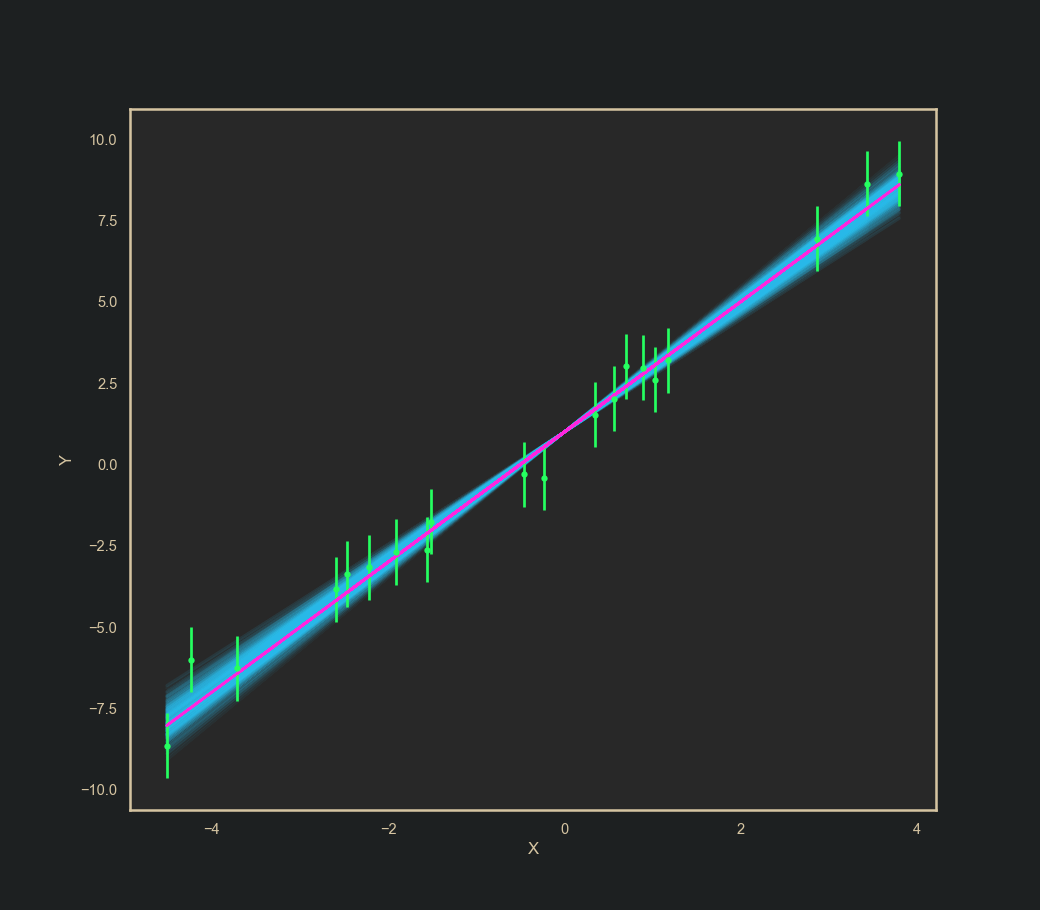

In [5]:
fig = fit.plot(data_color=green,latent_color=purple,fit_color=blue);
fig.savefig('ndata_fit_single.pdf',bbox_inches='tight')

<IPython.core.display.Javascript object>


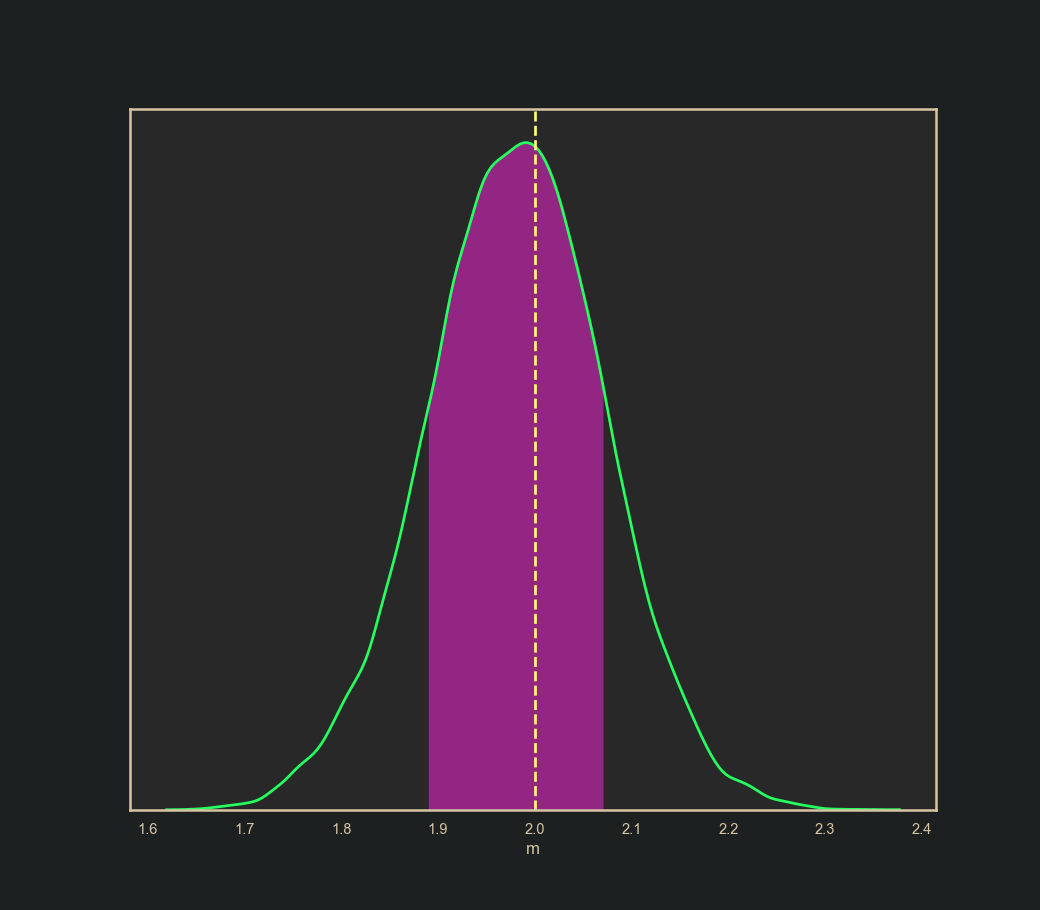

In [6]:
fig = fit.density_plot(cr=68,cr_alpha=.5,cr_color=purple,latent_color=yellow,color=green);
fig.savefig('ndata_cr_single.pdf',bbox_inches='tight')

Our fit looks nice, and we can see that we recover the simulated parameter very well. 

## Repeated experiments

If our model (which includes $sigma$) is correct, then if we were to simulate data from it many times, the credible regions from these fits should capture the data the correct percentage of the time.

We can use the fitting object to simulate this process. Data will be generated 100 times and fit. The 68% confidence region of the slope parameter will be calculated and we will see how many time the credible regions capture the true value.

In [7]:

normal_fit.check_confidence_regions(N=500,cr=68.)

331 of 500 fits (0.662000) were successfully inside the 68.000000 % confidence region
There are systematics!


<IPython.core.display.Javascript object>


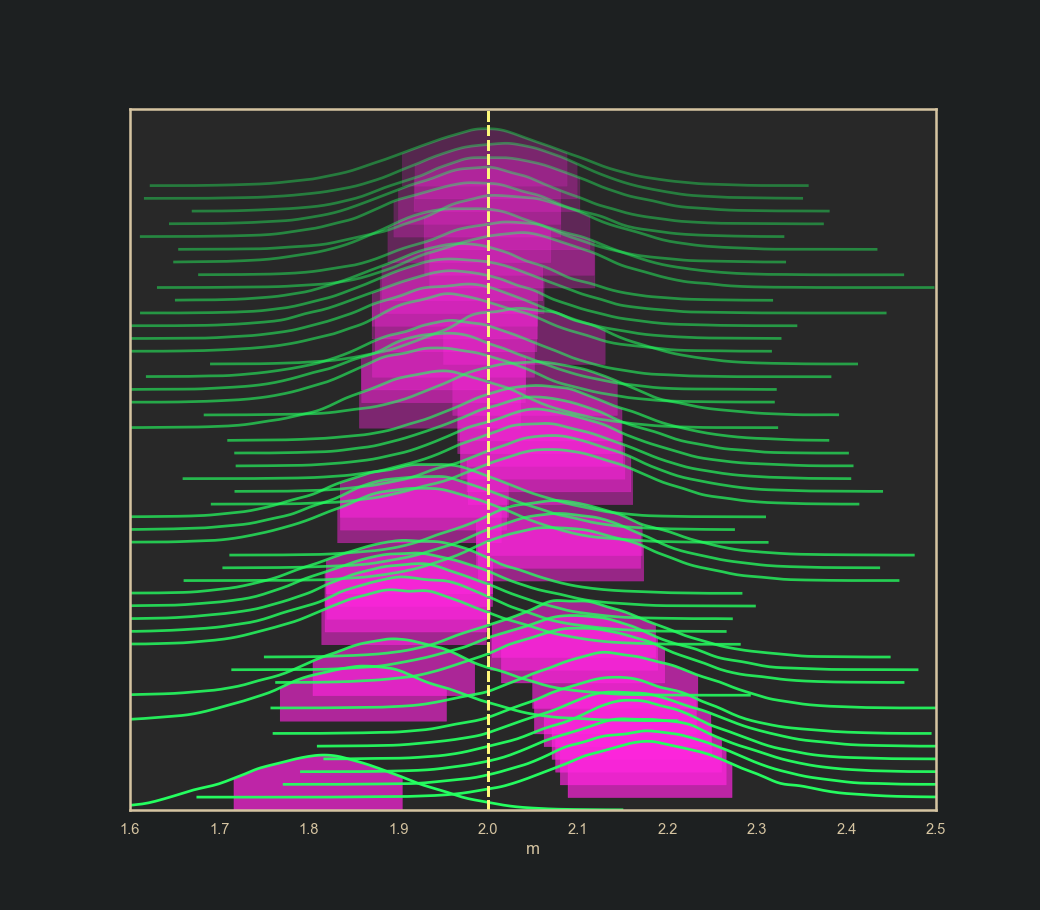

In [8]:
fig, ax = plt.subplots()
avg = [x._samples[:,0].mean() for x in  normal_fit.fits[::10]]
idx = np.argsort(np.abs(np.array(avg)-m_latent))

h=0
for fit in np.array(normal_fit.fits[::10])[idx[::-1]]:

    fit.density_plot(ax=ax,cr=68,cr_alpha=.7-h/100.,line_alpha=1-h/80., height=h,
                     cr_color=purple,latent_color=yellow,color=green);
    h+=1
    
ax.set_xlim(left=1.6,right=2.5)
ax.set_ylim(bottom=0,top=h+5)


fig.savefig('norm_all_plot.pdf', bbox_inches='tight')

In [9]:
# pass the type of class of the type of data you wnat to generate
# as well as the parameters
m_latent=2
b_latent=1
sigma=1
nu=3

normal_fit_tdata = NormalFit(TData,
                       [m_latent,b_latent,sigma,nu]
                      )


normal_fit_tdata.perform_fit()

fit = normal_fit_tdata.fits[0]

<IPython.core.display.Javascript object>


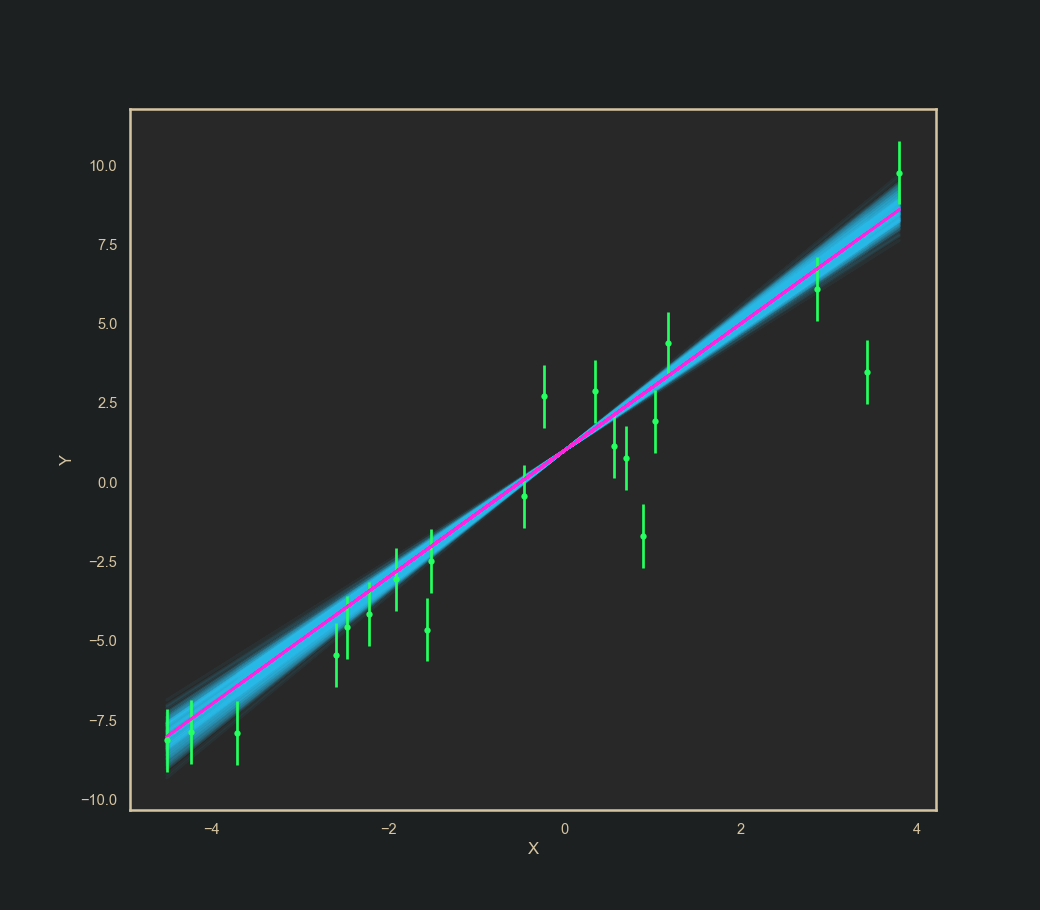

In [10]:
fig = fit.plot(data_color=green,latent_color=purple,fit_color=blue);
fig.savefig('tdata_fig_single.pdf',bbox_inches='tight')

<IPython.core.display.Javascript object>


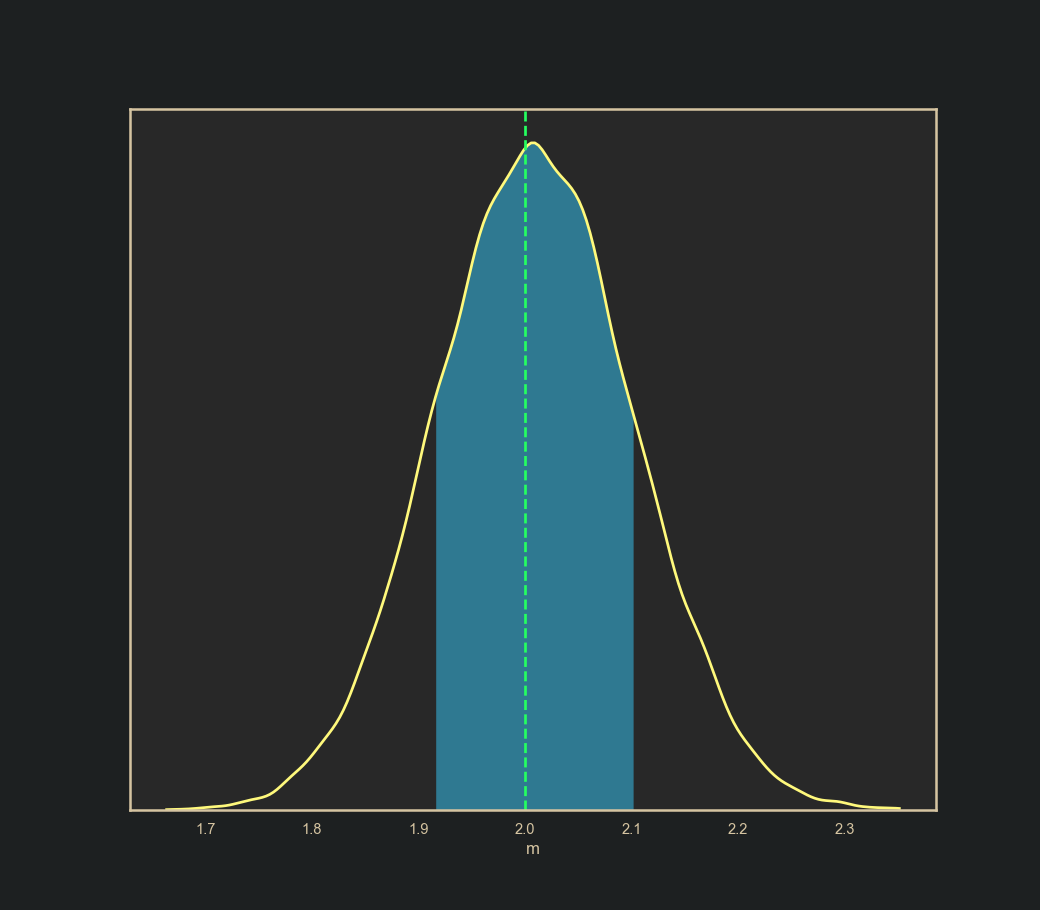

In [11]:
fig = fit.density_plot(cr=68,cr_alpha=.5, cr_color=blue,color=yellow,latent_color=green)
fig.savefig('tdata_cr_single.pdf',bbox_inches='tight')

In [12]:
normal_fit_tdata.check_confidence_regions(N=500,cr=68.)

235 of 500 fits (0.470000) were successfully inside the 68.000000 % confidence region
There are systematics!


<IPython.core.display.Javascript object>


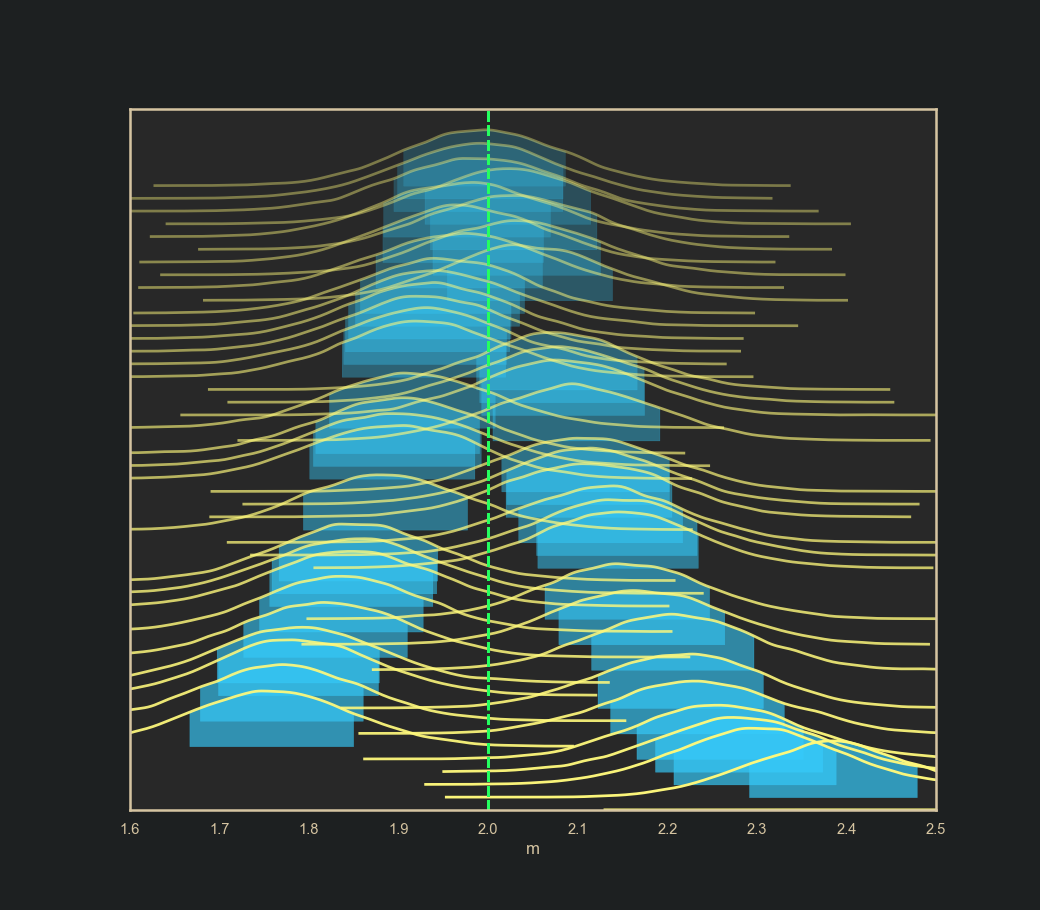

In [13]:
fig, ax = plt.subplots()

avg = [x._samples[:,0].mean() for x in  normal_fit_tdata.fits[::10]]
idx = np.argsort(np.abs(np.array(avg)-m_latent))

h=0

for fit in np.array(normal_fit_tdata.fits)[::10][idx[::-1]]:

    fit.density_plot(ax=ax,cr=68,cr_alpha=.7-h/100.,line_alpha=1-h/80., height=h,
                     cr_color=blue,color=yellow,latent_color=green);
    h+=1

ax.set_xlim(left=1.6,right=2.5)
ax.set_ylim(bottom=0,top=h+5)
fig.savefig('t_all_plot.pdf', bbox_inches='tight')

In [15]:
# pass the type of class of the type of data you wnat to generate
# as well as the parameters
m_latent=2
b_latent=1
sigma=1
nu=4

normalsys_fit_tdata = TFit(TData,
                               [m_latent,b_latent,sigma,nu],
                      )


normalsys_fit_tdata.perform_fit()

fit = normalsys_fit_tdata.fits[0]

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/jburgess/.environs/science3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


<IPython.core.display.Javascript object>


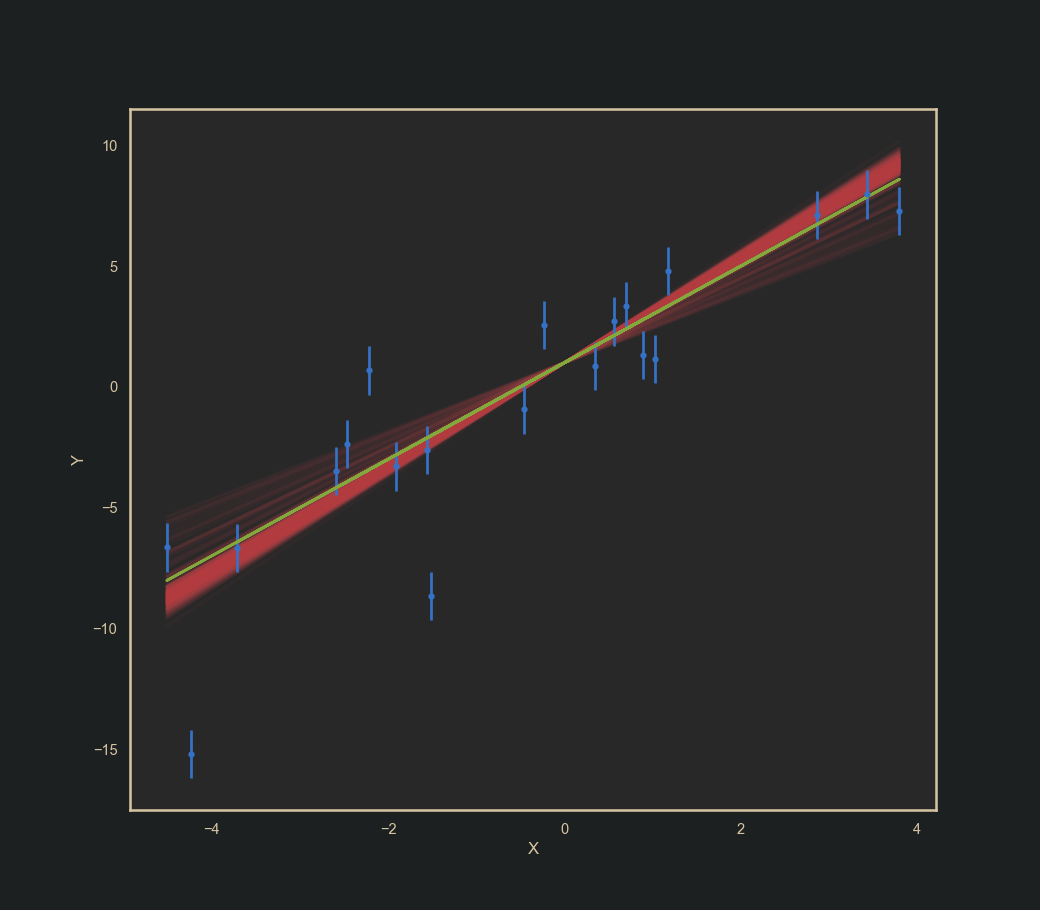

In [16]:
fit.plot();

<IPython.core.display.Javascript object>


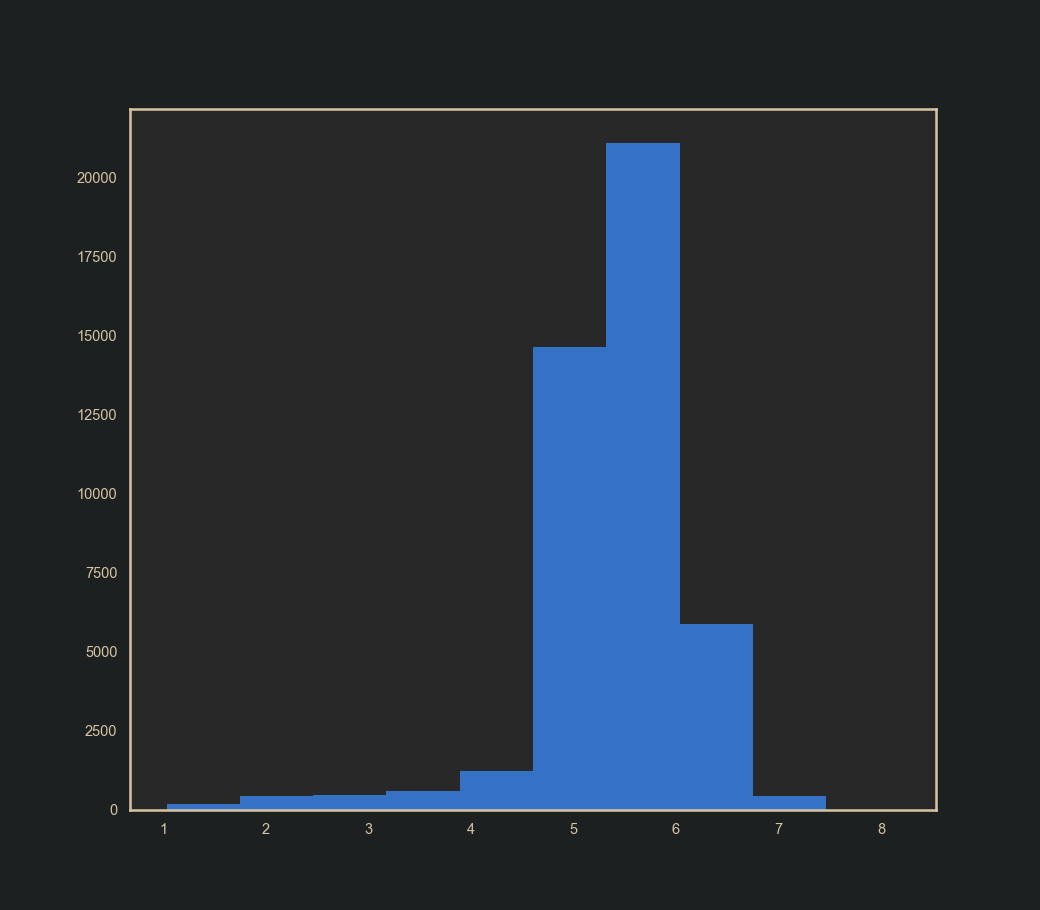

(array([1.7800e+02, 4.3700e+02, 4.8300e+02, 5.8400e+02, 1.2400e+03,
        1.4654e+04, 2.1109e+04, 5.8650e+03, 4.3900e+02, 1.1000e+01]),
 array([1.03181753, 1.74647202, 2.46112652, 3.17578101, 3.8904355 ,
        4.60508999, 5.31974448, 6.03439897, 6.74905346, 7.46370795,
        8.17836244]),
 <a list of 10 Patch objects>)

In [17]:
fig, ax = plt.subplots()

ax.hist(fit.samples[:,1]-1)

In [8]:
normalsys_fit_tdata.check_confidence_regions(N=100,cr=68.)

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/jburgess/.environs/science3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


34 of 100 fits (0.340000) were successfully inside the 68.000000 % confidence region
There are systematics!


<IPython.core.display.Javascript object>


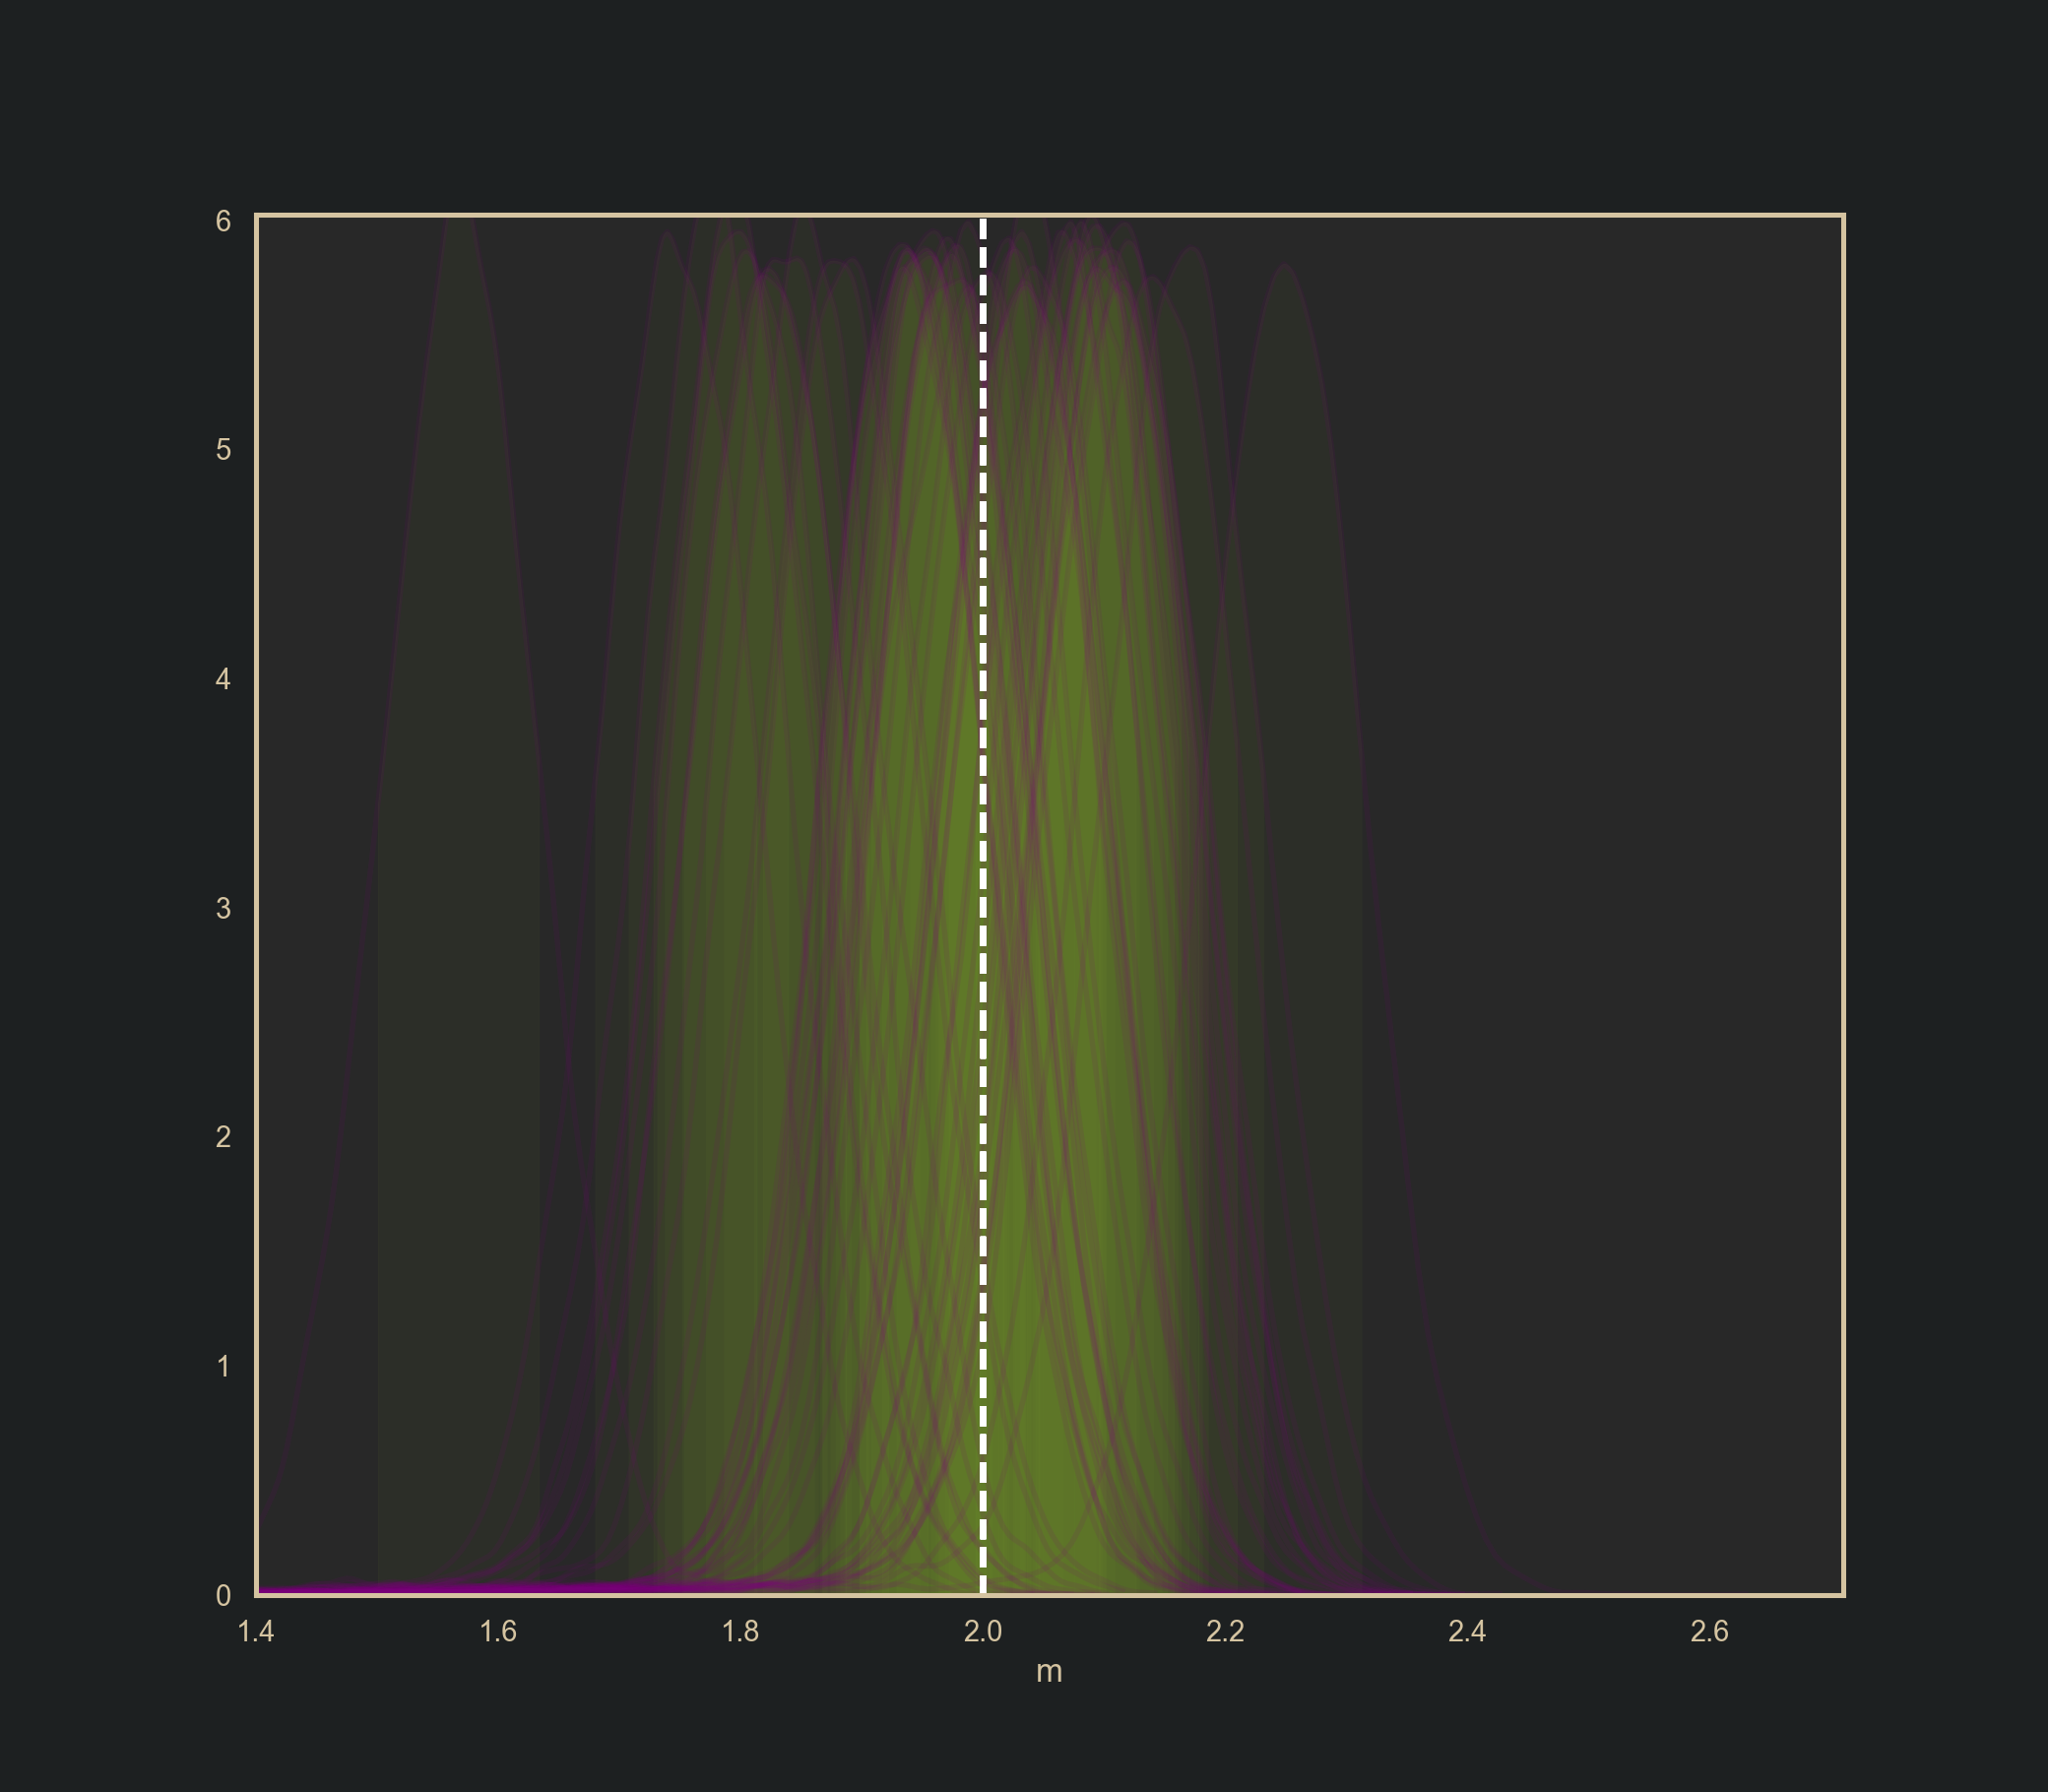

(1.4, 2.71041488920291)

In [18]:
fig, ax = plt.subplots()
for fit in normalsys_fit_tdata.fits[::2]:

    fit.density_plot(ax=ax,cr=68,cr_alpha=.05,line_alpha=.1,cr_color='g',color='purple');
    
ax.set_xlim(left=1.4)